# Main notebook
This notebook reproduces all the figures in the paper

- Bryan Van Scoy and Laurent Lessard. [The Speed-Robustness Trade-Off for First-Order Methods with Additive Gradient Noise](https://arxiv.org/abs/2109.05059) (2025)


In [ ]:
using Pkg
Pkg.activate(".")  # activate project (ensure this is run in the directory containing Project.toml and Manifest.toml)

In [1]:
include("optalg.jl")     # import necessary functions

using PyPlot
import PyPlot.rc
rc("text",usetex=true)   # LaTeX plots
DATA = "./data/"         # directory where we store data files
GENERATE_DATA = false    # whether we want to generate data (jld2 files) or not (only need to run once!)

DIR = "./figures/"       # directory where we save generated figures
FIGSIZE = [8.1,2.7]      # size of figures (inches)
SAVE_FIGS = true         # whether we want to save figures as pdfs or just plot them in the notebook

using SCS, MosekTools    # load alternative solvers (Clarabel is the default)
SOLVER = Mosek;          # chosen alternative solver (Mosek is fastest)

---

## Figure 1
Plot showing the trade-off between convergence rate and steady-state error for a toy example

In [2]:
if GENERATE_DATA
    # Generate data for left plot
    @time begin
        Random.seed!(0)
    
        T = 500    # time horizon
        N = 1000   # number of trials
        d = 10     # state dimension
    
        # function parameters
        m,L = 1, 10
        α1,α2,α3 = 0.18, 0.10, 0.03
        
        (e1,s1) = simulate_GD_quadratics(m, L, d, α1, T, N)
        (e2,s2) = simulate_GD_quadratics(m, L, d, α2, T, N)
        (e3,s3) = simulate_GD_quadratics(m, L, d, α3, T, N)
        
    end
    # Generate data for right plot
    @time begin
        Random.seed!(0)
    
        LT = 100000  # time horizon
        N = 1000     # number of trials
        d = 10       # state dimension
    
        # function parameters
        m,L = 1, 10
        Lα1,Lα2,Lα3 = 0.1, 0.01, 0.001
        
        (Le1,Ls1) = simulate_GD_quadratics(m, L, d, Lα1, LT, N)
        (Le2,Ls2) = simulate_GD_quadratics(m, L, d, Lα2, LT, N)
        (Le3,Ls3) = simulate_GD_quadratics(m, L, d, Lα3, LT, N)
    end
    @save DATA * "fig1_data.jld2" Lα1 Lα2 Lα3 Le1 Ls1 Le2 Ls2 Le3 Ls3 α1 α2 α3 e1 s1 e2 s2 e3 s3 m L d N T LT
end

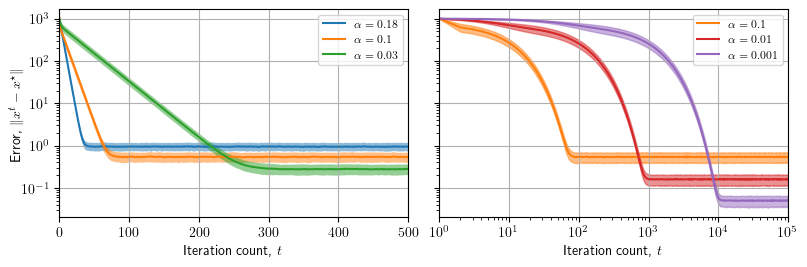

In [2]:
loadall( DATA * "fig1_data.jld2" )

function plot_convergence( pts, data, stdev, α; color=nothing, plot_type=semilogy )
    if color == nothing
        fill_between( pts, data-stdev, data+stdev, alpha=0.5 )
        plot_type( pts, data, label=L"$\alpha = " * "$α\$" )
    else
        fill_between( pts, data-stdev, data+stdev, alpha=0.5, color=color )
        plot_type( pts, data, color, label=L"$\alpha = " * "$α\$" )
    end
end

f, (ax1, ax2) = plt.subplots(1, 2, sharey=true, figsize=FIGSIZE)

# LEFT PLOT (SEMILOG SCALE)
plt.sca(ax1)
plot_convergence( 0:T, e1, s1, α1, plot_type=semilogy )
plot_convergence( 0:T, e2, s2, α2, plot_type=semilogy )
plot_convergence( 0:T, e3, s3, α3, plot_type=semilogy )
grid()
legend(loc="upper right",fontsize=8, labelspacing=0.5)
xlabel(L"Iteration count, $t$")
ylabel(L"Error,  $\|x^t-x^\star\|$", labelpad=-2)
xlim(0,T)

# RIGHT PLOT (LOGLOG SCALE)
plt.sca(ax2)
# subsample so the file doesn't get too large
ix = unique(Int.(round.(10 .^(range(0,stop=log10(LT),length=1000)))))
plot_convergence( ix, Le1[ix], Ls1[ix], Lα1, color = "C01", plot_type=loglog )
plot_convergence( ix, Le2[ix], Ls2[ix], Lα2, color = "C03", plot_type=loglog )
plot_convergence( ix, Le3[ix], Ls3[ix], Lα3, color = "C04", plot_type=loglog )
xticks(exp10.(0:5))
grid()
legend(loc="upper right",fontsize=8, labelspacing=0.5)
xlabel(L"Iteration count, $t$")
xlim(1,LT)

tight_layout(pad=0.8)
if SAVE_FIGS
    savefig(DIR * "fig1_demo_error_rate_tradeoff.pdf", pad_inches=0)
end

## Figure 2
Trade-off plots for $Q_{m,L}$ with cloud of possible algorithms

In [23]:
if GENERATE_DATA
    @time begin
        m = 1

        for L in [10, 100]
            κ = L/m
            N = 100

            ## QmL curve (heavy ball, robust heavy ball)
            # RHB sweep
            rhb_rho, rhb_gam = [], []
            ρvals = linspace((√κ-1)/(√κ+1),1,N)
            for ρ ∈ ρvals
                α,β,η = algo_params("RHB",m,L,ρ)
                push!(rhb_rho, get_rho_Q(α,β,η,m,L))
                push!(rhb_gam, get_gam_Q(α,β,η,m,L))
            end
            rhb_rho[end]=1 # deal with limiting case ρ=1
            rhb_gam[end]=0

            # GD sweep
            gd_rho, gd_gam = [], []
            αvals = [logspace(1e-6,2/(L+m),Int(N*4/5)); linspace(2/(L+m),2/L,Int(N*1/5))]
            for α ∈ αvals
                push!(gd_rho, get_rho_Q(α,0,0,m,L))
                push!(gd_gam, get_gam_Q(α,0,0,m,L))
            end

            # Heavy Ball with standard tuning
            α,β,η = algo_params("HB",m,L)
            hb_rho = get_rho_Q(α,β,η,m,L)
            hb_gam = get_gam_Q(α,β,η,m,L)

            # Triple Momentum with standard tuning
            α,β,η = algo_params("TM",m,L)
            tmm_rho = get_rho_Q(α,β,η,m,L)
            tmm_gam = get_gam_Q(α,β,η,m,L)
                        
            # Fast Gradient with standard tuning
            α,β,η = algo_params("FG",m,L)
            fgm_rho = get_rho_Q(α,β,η,m,L)
            fgm_gam = get_gam_Q(α,β,η,m,L)

            # get gradient method (1/L)
            gm1_rho = get_rho_Q(1/L,0,0,m,L)
            gm1_gam = get_gam_Q(1/L,0,0,m,L)
            
            # get gradient method (2/(L+m))
            gm2_rho = get_rho_Q(2/(L+m),0,0,m,L)
            gm2_gam = get_gam_Q(2/(L+m),0,0,m,L)
                
            # Cloud points
            Na,Nb,Nc = 500,201,200
            
            αvals  = logspace(1e-5, 4/L, Na)
            αηvals = linspace(-2/(L-m), 2/(L-m), Nb)
        
            rhovals = Float64[]
            gamvals = Float64[]
        
            for α ∈ αvals
                for αη ∈ αηvals
                    if αη ≥ 0
                        bvals = linspace(-1+L*αη, 1+m*αη, Nc)
                    else
                        bvals = linspace(-1+m*αη, 1+L*αη, Nc)
                    end
                    η = αη / α
                    for β ∈ bvals
                        rho = get_rho_Q(α,β,η,m,L)
                        if rho < 1
                            push!(rhovals, rho)
                            push!(gamvals, get_gam_Q(α,β,η,m,L) )
                        end
                    end
                end
            end
            @save DATA * "fig2_QmL_" * string(Int(κ)) * "_cloud.jld2" rhovals gamvals rhb_rho rhb_gam hb_rho hb_gam tmm_rho tmm_gam fgm_rho fgm_gam gd_rho gd_gam gm2_rho gm2_gam gm1_rho gm1_gam
        end
    end
end

 19.631433 seconds (230.96 M allocations: 5.189 GiB, 15.26% gc time)


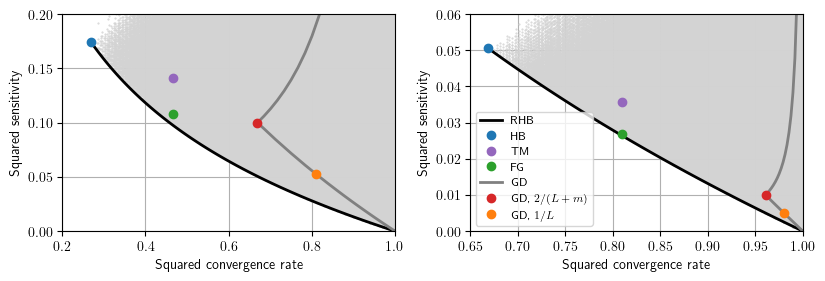

In [3]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=false, figsize=FIGSIZE)
s = 12
sdot = 1 # marker size for little dots

loadall(DATA * "fig2_QmL_10_cloud.jld2")
sca(ax1)
plot( rhovals[:].^2, gamvals[:].^2, ".", color="lightgray", markersize=sdot, rasterized=true )
plot( rhb_rho.^2, rhb_gam.^2, "-", linewidth=2, color="black", label="RHB")
plot( hb_rho.^2, hb_gam.^2, "C0.", label="HB", markersize=s )
plot( tmm_rho.^2, tmm_gam.^2, "C4.", label="TM", markersize=s )
plot( fgm_rho.^2, fgm_gam.^2, "C2.", label="FG", markersize=s )
plot( gd_rho.^2, gd_gam.^2, "-", color="gray", linewidth=2, label="GD")
plot( gm2_rho.^2, gm2_gam.^2, "C3.", label=L"GD, $2/(L+m)$", markersize=s )
plot( gm1_rho.^2, gm1_gam.^2, "C1.", label=L"GD, $1/L$", markersize=s )
axis((.2,1,0,.20)) # m=1, L=10
xlabel("Squared convergence rate")
ylabel("Squared sensitivity")
# legend(loc="lower left",ncol=1,columnspacing=0.5,labelspacing=0.5,fontsize=8)
grid()

loadall(DATA * "fig2_QmL_100_cloud.jld2")
sca(ax2)
plot( rhovals[:].^2, gamvals[:].^2, ".", color="lightgray", markersize=sdot, rasterized=true )
plot( rhb_rho.^2, rhb_gam.^2, "-", linewidth=2, color="black", label="RHB")
plot( hb_rho.^2, hb_gam.^2, "C0.", label="HB", markersize=s )
plot( tmm_rho.^2, tmm_gam.^2, "C4.", label="TM", markersize=s )
plot( fgm_rho.^2, fgm_gam.^2, "C2.", label="FG", markersize=s )
plot( gd_rho.^2, gd_gam.^2, "-", color="gray", linewidth=2, label="GD")
plot( gm2_rho.^2, gm2_gam.^2, "C3.", label=L"GD, $2/(L+m)$", markersize=s )
plot( gm1_rho.^2, gm1_gam.^2, "C1.", label=L"GD, $1/L$", markersize=s )
axis((0.65,1,0,0.06)) # m=1, L=100
xlabel("Squared convergence rate")
ylabel("Squared sensitivity")
legend(loc="lower left",ncol=1,columnspacing=0.5,labelspacing=0.5,fontsize=8)
grid()

tight_layout(pad=0.3, w_pad=1)
if SAVE_FIGS
    savefig(DIR * "fig2_QmL_cloud_plot.pdf", dpi=600, pad_inches=0)
end

## Figure 3
Trade-off plots for $F_{m,L}$ with cloud of possible algorithms. First we generate individual algorithms and sweeps (for RAM, RM, GD).

In [44]:
if GENERATE_DATA
    @time begin
        m = 1
        N = 100

        for L in [10, 100]
            κ = L/m

            # Heavy Ball with standard tuning
            α,β,η = algo_params("HB",m,L)
            hb_rho = get_rho_F(α,β,η,m,L,solver=SOLVER)
            hb_gam = get_gam_F(α,β,η,m,L,solver=SOLVER)

            # Triple Momentum with standard tuning
            α,β,η = algo_params("TM",m,L)
            tmm_rho = get_rho_F(α,β,η,m,L,solver=SOLVER)
            tmm_gam = get_gam_F(α,β,η,m,L,solver=SOLVER,ℓ=4) # ℓ=6 returns solver error with Mosek for some reason
                        
            # Fast Gradient with standard tuning
            α,β,η = algo_params("FG",m,L)
            fgm_rho = get_rho_F(α,β,η,m,L,solver=SOLVER)
            fgm_gam = get_gam_F(α,β,η,m,L,solver=SOLVER)

            # get gradient method (1/L)
            α,β,η = algo_params("GD 1/L",m,L)
            gm1_rho = get_rho_F(α,β,η,m,L,solver=SOLVER)
            gm1_gam = get_gam_F(α,β,η,m,L,solver=SOLVER)
            
            # get gradient method (2/(L+m))
            α,β,η = algo_params("GD 2/(L+m)",m,L)
            gm2_rho = get_rho_F(α,β,η,m,L,solver=SOLVER)
            gm2_gam = get_gam_F(α,β,η,m,L,solver=SOLVER)

            # RAM sweep
            ram_rho, ram_gam = [], []
            ρvals = linspace(1-1/√κ, 1, N)
            for ρ ∈ ρvals
                α,β,η = algo_params("RAM",m,L,ρ)
                push!(ram_rho, get_rho_F(α,β,η,m,L,solver=SOLVER))
                push!(ram_gam, get_gam_F(α,β,η,m,L,solver=SOLVER))
            end
            ram_rho[end] = 1 # deal with limiting case of ρ=1
            ram_gam[end] = 0

            # RM sweep
            rm_rho, rm_gam = [], []
            ρvals = linspace(1-1/√κ, 1-1/κ, N)
            for ρ ∈ ρvals
                α,β,η = algo_params("RM",m,L,ρ)
                push!(rm_rho, get_rho_F(α,β,η,m,L,solver=SOLVER))
                push!(rm_gam, get_gam_F(α,β,η,m,L,solver=SOLVER))
            end
            rm_rho[end] = gm1_rho # deal with limiting case (limit is GM)
            rm_gam[end] = gm1_gam

            # GD sweep
            gd_rho, gd_gam = [], []
            ρvals = linspace((L-m)/(L+m),1,N)
            for ρ ∈ ρvals
                α,β,η = algo_params("GD",m,L,ρ)
                push!(gd_rho, get_rho_F(α,β,η,m,L,solver=SOLVER))
                push!(gd_gam, get_gam_F(α,β,η,m,L,solver=SOLVER))
            end
            gd_rho[end] = 1 # deal with limiting case of ρ=1
            gd_gam[end] = 0
            
            @save DATA * "fig3_FmL_" * string(Int(κ)) * "_algos.jld2" hb_rho hb_gam tmm_rho tmm_gam fgm_rho fgm_gam rm_rho rm_gam ram_rho ram_gam gd_rho gd_gam gm2_rho gm2_gam gm1_rho gm1_gam L m κ
        end
    end
end

200.857293 seconds (178.89 M allocations: 30.336 GiB, 3.37% gc time, 4.62% compilation time: 3% of which was recompilation)


Now we generate a brute-force search over algorithms. This takes many hours, so additional steps are taken:
- perform error handling so if solver fails we do not jeopardize the run (just store `NaN` on error)
- use multithreading speed up the code (for multi-core processors)
- could also distribute to multiple CPUs via `@distributed` but we did not implement this.

Here is the process:
- We use `batch_run()` to iterate through the whole grid using $\ell=6$ with `Mosek`.
- All cases succeeded in finding $\rho$. When $\rho < 1$, we attempt to find $\gamma$. This sometimes failed:
    - For $L/m = 10$, we found $\frac{31016}{510000}$ (6%) produced errors.
    - For $L/m = 100$, we found $\frac{21142}{510000}$ (4%) produced errors.
- Most of these solver failures occured when $\rho$ was close to 1.
- We use `batch_run_extra()` to re-solve the cases with $\rho<0.99$ using `Clarabel` instead of `Mosek`.
    - For $L/m = 10$, we re-solved $5073$ cases. Only $547$ still produced errors.
    - For $L/m = 100$, we re-solved $590$ cases. Only $90$ still produced errors.

In [128]:
using Base.Threads, ProgressMeter

# function for batch run. In the paper, we used m=1, L=10 or 100, (Na,Nb,Nc)=(200,51,50).
function batch_run(m,L,(Na,Nb,Nc),fname;solver=SOLVER)

    nt = nthreads()
    if nt == 1
        println("Executing batch run with 1 thread")
    else
        println("Executing batch run with $(nt) threads")
    end
    p = Progress(Na*Nb*Nc)
    
    rhovals = Array{Float64}(undef,Na,Nb,Nc)
    gamvals = Array{Float64}(undef,Na,Nb,Nc)
    paramvals = Array{NTuple{3,Float64}}(undef,Na,Nb,Nc)
     
    αvals  = logspace(1e-5, 4/L, Na)
    αηvals = linspace(-2/(L-m), 2/(L-m), Nb)

    @threads for (i,α) ∈ collect(enumerate(αvals))
        for (j,αη) ∈ enumerate(αηvals)
            bvals = αη ≥ 0 ? linspace(-1+L*αη, 1+m*αη, Nc) : linspace(-1+m*αη, 1+L*αη, Nc)
            η = αη / α
            for (k,β) ∈ enumerate(bvals)
                key = (α,β,η)

                paramvals[i,j,k] = key

                rho = get_rho_F(α,β,η,m,L,solver=solver)
                rhovals[i,j,k] = rho
                if rho < 1
                    gam = get_gam_F(α,β,η,m,L,solver=solver)
                    gamvals[i,j,k] = gam
                else
                    gamvals[i,j,k] = NaN
                end
                next!(p)
            end # beta
        end # eta
    end # alpha
    @save fname rhovals gamvals paramvals m L
end

# function for extra batch run. In the paper, we used m=1, L=10 or 100, (Na,Nb,Nc)=(200,51,50).
# use this to try something different for the cases that returned errors on the first batch run
# assume fname_old contains original data, store new data in fname_new
function batch_run_extra(fname_old, fname_new; solver=SOLVER, ℓ=6)

    nt = nthreads()
    if nt == 1
        println("Executing batch run with 1 thread")
    else
        println("Executing batch run with $(nt) threads")
    end

    @load fname_old rhovals gamvals paramvals m L
    Na,Nb,Nc = size(rhovals)

    # typical fixable errors occur when rho < 0.99 and gam = NaN.
    # in such cases, using a different solver often fixes the problem!
    p = Progress( length( [ nothing for i in 1:Na*Nb*Nc if rhovals[i] < 0.99 && isnan(gamvals[i]) ] ) )

    # resolve error cases
    @threads for i in 1:Na
        for j in 1:Nb
            for k in 1:Nc
                if rhovals[i,j,k] < 0.99 && isnan(gamvals[i,j,k])
                    (α,β,η) = paramvals[i,j,k]
                    gam = get_gam_F(α,β,η,m,L,solver=solver,ℓ=ℓ)
                    gamvals[i,j,k] = gam
                    next!(p)
                end
            end
        end
    end
    @save fname_new rhovals gamvals paramvals m L
end
;

In [27]:
# MAIN BATCH RUN -- TOOK ROUGHLY 24 HOURS (using 8-core multithreading)
if GENERATE_DATA
    @assert(false, "OVERWRITE EXISTING DATA FILE AND RUN HUGE JOB? ARE YOU SURE?")
    m = 1
    for L in [10, 100]
        println()
        println("Starting batch job with L = $L")
        println()
        # create blank data file and start big run (takes many hours)
        fname = DATA * "fig3_FmL_" * string(Int(L/m)) * "_cloud_main.jld2"
        @time batch_run(m,L,(200,51,50),fname)
        println()
        println("batch job complete!")
    end
end


Starting batch job with L = 10

Executing batch run with 8 threads


Progress: 100%|█████████████████████████████████████████| Time: 11:47:33


42453.827364 seconds (138.91 G allocations: 21.678 TiB, 9.39% gc time, 6718 lock conflicts, 0.00% compilation time)

batch job complete!

Starting batch job with L = 100

Executing batch run with 8 threads


Progress: 100%|█████████████████████████████████████████| Time: 11:52:13


42733.252638 seconds (132.16 G allocations: 20.941 TiB, 9.31% gc time, 6566 lock conflicts)

batch job complete!


In [129]:
# EXTRA BATCH RUN -- TOOK ROUGHLY 6 MINUTES
if GENERATE_DATA
    @assert(false, "OVERWRITE EXISTING DATA FILE AND RUN HUGE JOB? ARE YOU SURE?")
    m = 1
    for L in [10, 100]
        println()
        println("Starting batch job with L = $L")
        println()
        # try using a different solver to deal with errors
        fname_old = DATA * "fig3_FmL_" * string(Int(L/m)) * "_cloud_main.jld2"
        fname_new = DATA * "fig3_FmL_" * string(Int(L/m)) * "_cloud_main_extra.jld2"
        @time batch_run_extra(fname_old, fname_new, solver=Clarabel)
        println()
        println("extra batch job complete!")
    end
end


Starting batch job with L = 10

Executing batch run with 8 threads


Progress: 100%|█████████████████████████████████████████| Time: 0:05:10


310.995650 seconds (221.73 M allocations: 80.902 GiB, 5.52% gc time, 61 lock conflicts, 0.59% compilation time)

extra batch job complete!

Starting batch job with L = 100

Executing batch run with 8 threads


Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


 43.983321 seconds (25.62 M allocations: 9.421 GiB, 5.16% gc time, 9 lock conflicts)

extra batch job complete!


In [153]:
# make a tally of errors in the different cases
function error_tally(fname)
    @load fname rhovals gamvals paramvals m L
    count_stable, count_unstable, count_rho_error, count_gam_error, count_low_rho_error = 0,0,0,0,0
    for (i,rho) in enumerate(rhovals)
        if isnan(rho)
            count_rho_error += 1
        elseif rho < 1
            if !isnan(gamvals[i])
                count_stable += 1
            else
                count_gam_error += 1
                if rho < 0.99
                    count_low_rho_error += 1
                end
            end
        else
            @assert rho >= 1
            count_unstable += 1
        end
    end
    println( "ERROR TALLY, L/m = $(Int(L/m))" )
    println( "==============================" )
    println( "Stable (ρ < 1):       $count_stable" )
    println( "Unstable (ρ ≥ 1):     $count_unstable" )
    println( "Error computing ρ:    $count_rho_error" )
    println( "Error computing γ:    $count_gam_error" )
    println( "Error proportion:     $( round((count_rho_error + count_gam_error) / length(rhovals),sigdigits=2) )" )
    println( "Errors with ρ < 0.99: $count_low_rho_error" ) 
    println( "Total cases tested:   $(length(rhovals))" )
    println()
end

error_tally( DATA * "fig4_FmL_10_cloud_main.jld2" )
error_tally( DATA * "fig4_FmL_10_cloud_main_extra.jld2" )
error_tally( DATA * "fig4_FmL_100_cloud_main.jld2" )
error_tally( DATA * "fig4_FmL_100_cloud_main_extra.jld2" )

ERROR TALLY, L/m = 10
Stable (ρ < 1):       391859
Unstable (ρ ≥ 1):     87125
Error computing ρ:    0
Error computing γ:    31016
Error proportion:     0.061
Errors with ρ < 0.99: 5073
Total cases tested:   510000

ERROR TALLY, L/m = 10
Stable (ρ < 1):       396385
Unstable (ρ ≥ 1):     87125
Error computing ρ:    0
Error computing γ:    26490
Error proportion:     0.052
Errors with ρ < 0.99: 547
Total cases tested:   510000

ERROR TALLY, L/m = 100
Stable (ρ < 1):       390587
Unstable (ρ ≥ 1):     98271
Error computing ρ:    0
Error computing γ:    21142
Error proportion:     0.041
Errors with ρ < 0.99: 590
Total cases tested:   510000

ERROR TALLY, L/m = 100
Stable (ρ < 1):       391087
Unstable (ρ ≥ 1):     98271
Error computing ρ:    0
Error computing γ:    20642
Error proportion:     0.04
Errors with ρ < 0.99: 90
Total cases tested:   510000



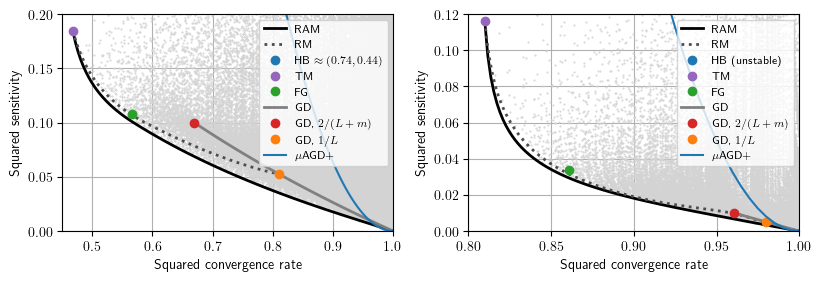

In [4]:
using Printf

f, (ax1, ax2) = plt.subplots(1, 2, sharey=false, figsize=FIGSIZE)
s = 12

## FIRST PLOT (L/m = 10)
sca(ax1)
loadall(DATA * "fig3_FmL_10_algos.jld2")
@load DATA * "fig3_FmL_10_cloud_main_extra.jld2" rhovals gamvals paramvals

rhov,gamv = Float64[], Float64[]

for (i,rho) in enumerate(rhovals)
    gam = gamvals[i]
    if rho < 1 && !isnan(gam)
        push!(rhov,rho)
        push!(gamv,gam)
    end
end

plot( rhov[:].^2, gamv[:].^2, ".", color="lightgray", markersize=1, rasterized=true )

plot( ram_rho.^2, ram_gam.^2, "-", color=(0,0,0), linewidth=2, label="RAM")
plot( rm_rho.^2, rm_gam.^2, ":", color=(.3,.3,.3), linewidth=2, label="RM")

label_str = L"HB $\approx (" * @sprintf("%.2f", hb_rho.^2) * "," * @sprintf("%.2f", hb_gam.^2) * L")$"

plot( hb_rho.^2, hb_gam.^2, "C0.", label=label_str, markersize=s )
plot( tmm_rho.^2, tmm_gam.^2, "C4.", label="TM", markersize=s )
plot( fgm_rho.^2, fgm_gam.^2, "C2.", label="FG", markersize=s )
plot( gd_rho.^2, gd_gam.^2, "-", color="gray", linewidth=2, label="GD")
plot( gm2_rho.^2, gm2_gam.^2, "C3.", label=L"GD, $2/(L+m)$", markersize=s )
plot( gm1_rho.^2, gm1_gam.^2, "C1.", label=L"GD, $1/L$", markersize=s )

# cohen et al
c = range(0, stop=sqrt(κ), length=200)
plot( 1 .- c/sqrt(κ), 2*c.^2/(m*sqrt(m*L)), label=L"$\mu$AGD+")

axis((0.45,1,0,0.2))
xlabel("Squared convergence rate")
ylabel("Squared sensitivity")

legend(loc="upper right",ncol=1,columnspacing=0.5,labelspacing=0.5,fontsize=8)
grid()


## SECOND PLOT (L/m = 100)
sca(ax2)
loadall(DATA * "fig3_FmL_100_algos.jld2")
@load DATA * "fig3_FmL_100_cloud_main_extra.jld2" rhovals gamvals paramvals

rhov,gamv = Float64[], Float64[]

for (i,rho) in enumerate(rhovals)
    gam = gamvals[i]
    if rho < 1 && !isnan(gam)
        push!(rhov,rho)
        push!(gamv,gam)
    end
end

plot( rhov.^2, gamv.^2, ".", color="lightgray", markersize=1, rasterized=true )

plot( ram_rho.^2, ram_gam.^2, "-", color=(0,0,0), linewidth=2, label="RAM")
plot( rm_rho.^2, rm_gam.^2, ":", color=(.3,.3,.3), linewidth=2, label="RM")
plot( hb_rho.^2, hb_gam.^2, "C0.", label="HB (unstable)", markersize=s )
plot( tmm_rho.^2, tmm_gam.^2, "C4.", label="TM", markersize=s )
plot( fgm_rho.^2, fgm_gam.^2, "C2.", label="FG", markersize=s )
plot( gd_rho.^2, gd_gam.^2, "-", color="gray", linewidth=2, label="GD")
plot( gm2_rho.^2, gm2_gam.^2, "C3.", label=L"GD, $2/(L+m)$", markersize=s )
plot( gm1_rho.^2, gm1_gam.^2, "C1.", label=L"GD, $1/L$", markersize=s )

# cohen et al
c = range(0, stop=sqrt(κ), length=200)
plot( 1 .- c/sqrt(κ), 2*c.^2/(m*sqrt(m*L)), label=L"$\mu$AGD+")

axis((0.8,1,0,0.12))
xlabel("Squared convergence rate")
ylabel("Squared sensitivity")

legend(loc="upper right",ncol=1,columnspacing=0.5,labelspacing=0.5,fontsize=8)
grid()

tight_layout(pad=0.3, w_pad=1)
if SAVE_FIGS
    savefig(DIR * "fig3_FmL_cloud_plot.pdf", dpi=600, pad_inches=0)
end

## Figure 4
- Pareto region plot showing different algorithm classes (requires data generated for $F_{m,L}$ in Fig. 3)
- Plot from [Michalowski et al. (2020)](https://doi.org/10.1080/00207179.2020.1745286) overlaid with RAM

In [427]:
if GENERATE_DATA
    @time begin
        m = 1
        N = 100
        
        for L in [5, 50]
            κ = L/m
        
            ## QmL curve (heavy ball, robust heavy ball)
            # RHB sweep
            rhb_rho, rhb_gam = [], []
            ρvals = linspace((√κ-1)/(√κ+1),1,N)
            for ρ ∈ ρvals
                α,β,η = algo_params("RHB",m,L,ρ)
                push!(rhb_rho, get_rho_Q(α,β,η,m,L))
                push!(rhb_gam, get_gam_Q(α,β,η,m,L))
            end
            rhb_rho[end] = 1 # deal with limiting case ρ=1
            rhb_gam[end] = 0
            
            # HB with standard tuning
            α,β,η = algo_params("HB",m,L)
            hb_rho = get_rho_Q(α,β,η,m,L)
            hb_gam = get_gam_Q(α,β,η,m,L)
            
            ## FmL curve (triple momentum, robust momentum, fast gradient, robust accelerated method)
            # RAM SWEEP (FmL)
            ram_rho, ram_gam = [], []
            ρvals = linspace(1-1/√κ, 1, N)
            for ρ ∈ ρvals
                α,β,η = algo_params("RAM",m,L,ρ)
                push!(ram_rho, get_rho_F(α,β,η,m,L,solver=SOLVER))
                push!(ram_gam, get_gam_F(α,β,η,m,L,solver=SOLVER))
            end
            ram_rho[end] = 1 # deal with limiting case ρ=1
            ram_gam[end] = 0

            # GD with conservative stepsize (suboptimal for FmL)
            α = 1/L
            gd1_rho = get_rho_F(α,0,0,m,L,solver=SOLVER)
            gd1_gam = get_gam_F(α,0,0,m,L,solver=SOLVER)

            # GD with optimal stepsize for FmL
            α = 2/(L+m)
            gd2_rho = get_rho_F(α,0,0,m,L,solver=SOLVER)
            gd2_gam = get_gam_F(α,0,0,m,L,solver=SOLVER)
                
            # Triple Momentum with standard tuning
            α,β,η = algo_params("TM",m,L)
            tmm_rho = get_rho_F(α,β,η,m,L,solver=SOLVER)
            tmm_gam = get_gam_F(α,β,η,m,L,solver=SOLVER)
                        
            # Fast Gradient with standard tuning
            α,β,η = algo_params("FG",m,L)
            fgm_rho = get_rho_F(α,β,η,m,L,solver=SOLVER)
            fgm_gam = get_gam_F(α,β,η,m,L,solver=SOLVER)
        
            @save DATA * "fig4_" * string(Int(κ)) * "_data.jld2" rhb_rho rhb_gam hb_rho hb_gam ram_rho ram_gam tmm_rho tmm_gam fgm_rho fgm_gam gd1_rho gd1_gam gd2_rho gd2_gam 
        end
    end
end

 70.340549 seconds (58.10 M allocations: 10.276 GiB, 4.10% gc time)


In [381]:
using Base.Threads, ProgressMeter

# function for batch run. In the paper, we used m=100, (Na,Nb)=(100,101).
function batch_run_hb(m,L,(Na,Nb),fname;solver=SOLVER)

    nt = nthreads()
    if nt == 1
        println("Executing batch run with 1 thread")
    else
        println("Executing batch run with $(nt) threads")
    end
    p = Progress(Na*Nb)
    
    rhovals = Array{Float64}(undef,Na,Nb)
    gamvals = Array{Float64}(undef,Na,Nb)
    paramvals = Array{NTuple{3,Float64}}(undef,Na,Nb)

    ε=1e-5
    αvals = linspace(ε, 4/L-ε, Na)
    βvals = linspace(-1+ε,1-ε, Nb)

    @threads for (i,α) ∈ collect(enumerate(αvals))
        for (j,β) ∈ enumerate(βvals)
            η = 0
            key = (α,β,η)
            paramvals[i,j] = key
            rho = get_rho_F(α,β,η,m,L,solver=solver)
            rhovals[i,j] = rho
            if rho < 1
                gam = get_gam_F(α,β,η,m,L,solver=solver)
                gamvals[i,j] = gam
            else
                gamvals[i,j] = NaN
            end
            next!(p)
        end # beta
    end # alpha
    @save fname rhovals gamvals paramvals m L
end

# function for batch run. In the paper, we used m=100, (Na,Nb)=(100,101).
function batch_run_fg(m,L,(Na,Nb),fname;solver=SOLVER)

    nt = nthreads()
    if nt == 1
        println("Executing batch run with 1 thread")
    else
        println("Executing batch run with $(nt) threads")
    end
    p = Progress(Na*Nb)
    
    rhovals = Array{Float64}(undef,Na,Nb)
    gamvals = Array{Float64}(undef,Na,Nb)
    paramvals = Array{NTuple{3,Float64}}(undef,Na,Nb)

    ε=1e-5
    αvals = linspace(ε, 4/L-ε, Na)
    αβvals = linspace(-1+ε,1-ε, Nb)

    #  αvals  = logspace(1e-5, 4/L, Na)
    # αηvals = linspace(-2/(L-m), 2/(L-m), Nb)
    # bvals = αη ≥ 0 ? linspace(-1+L*αη, 1+m*αη, Nc) : linspace(-1+m*αη, 1+L*αη, Nc)

    @threads for (i,α) ∈ collect(enumerate(αvals))
        βvals =  α < 2/(L+m) ? linspace(-1/(1-m*α),1/(1-m*α),Nb) : linspace(-1/(L*α-1),1/(L*α-1),Nb)
        for (j,β) ∈ enumerate(βvals)
            η = β
            key = (α,β,η)
            paramvals[i,j] = key
            rho = get_rho_F(α,β,η,m,L,solver=solver)
            rhovals[i,j] = rho
            if rho < 1
                gam = get_gam_F(α,β,η,m,L,solver=solver)
                gamvals[i,j] = gam
            else
                gamvals[i,j] = NaN
            end
            next!(p)
        end # beta
    end # alpha
    @save fname rhovals gamvals paramvals m L
end
;

In [415]:
# MAIN BATCH RUN -- TOOK ROUGHLY 90 MINUTES (using 8-core multithreading)
if GENERATE_DATA
    @assert(false, "OVERWRITE EXISTING DATA FILE AND RUN HUGE JOB? ARE YOU SURE?")
    m = 1
    for L in [100]
        println()
        println("Starting HB batch job with L = $L")
        println()
        # create blank data file and start big run
        fname = DATA * "fig4_FmL_" * string(Int(L/m)) * "_pareto_hb.jld2"
        @time batch_run_hb(m,L,(200,201),fname)
        println()
        println("HB batch job complete!")
        println()
        println("Starting FG batch job with L = $L")
        println()
        # create blank data file and start big run
        fname = DATA * "fig4_FmL_" * string(Int(L/m)) * "_pareto_fg.jld2"
        @time batch_run_fg(m,L,(200,201),fname)
        println()
        println("FG batch job complete!")
    end
end


Starting HB batch job with L = 100

Executing batch run with 8 threads


Progress: 100%|█████████████████████████████████████████| Time: 0:42:50


2570.966654 seconds (9.51 G allocations: 1.008 TiB, 8.22% gc time, 513 lock conflicts, 0.04% compilation time)

HB batch job complete!

Starting FG batch job with L = 100

Executing batch run with 8 threads


Progress: 100%|█████████████████████████████████████████| Time: 0:48:09


2889.970241 seconds (9.88 G allocations: 1.272 TiB, 9.42% gc time, 539 lock conflicts)

FG batch job complete!


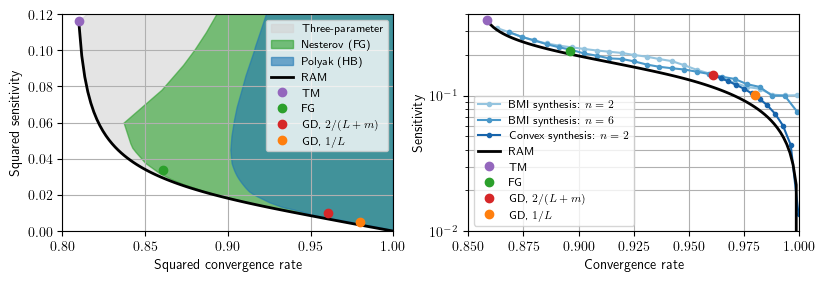

In [5]:
loadall(DATA * "fig3_FmL_100_algos.jld2")

clip = sqrt(0.25)  # where to clip gamma for the purpose of finding convex hull

# TM points
rhovals_tm = [ram_rho; 1]
gamvals_tm = [ram_gam; clip]

# HB points
@load DATA * "fig4_FmL_100_pareto_hb.jld2" rhovals gamvals paramvals
Na,Nb = size(rhovals)

rhovals_hb = [1.0]
gamvals_hb = [clip]

for i=1:Na, j=1:Nb
    ρ = rhovals[i,j]
    γ = gamvals[i,j]
    if ρ < 1 && γ < clip
        push!(rhovals_hb, ρ)
        push!(gamvals_hb, γ)
    end
end

# FG points
@load DATA * "fig4_FmL_100_pareto_fg.jld2" rhovals gamvals paramvals
Na,Nb = size(rhovals)

rhovals_fg = [1.0]
gamvals_fg = [clip]

for i=1:Na, j=1:Nb
    ρ = rhovals[i,j]
    γ = gamvals[i,j]
    if ρ < 1 && γ < clip
        push!(rhovals_fg, ρ)
        push!(gamvals_fg, γ)
    end
end

using ConvexHulls2d

function get_convex_hull( rhovals, gamvals )    
    pts = [ [ρ^2,γ^2] for (ρ,γ) in zip( rhovals, gamvals ) ]  # requires a list of AbstractVectors
    ch = ConvexHulls2d.ConvexHull( pts )
    chull = ConvexHulls2d.vertices(ch)
    rho_hull = first.(chull)
    gam_hull = last.(chull)
    return (sqrt.(rho_hull), sqrt.(gam_hull))
end

# rescale points before taking the convex hull (this makes the region convex)
# then undo the scaling to recover the original set.
# alternatively we could use some sort of concave hull approximation but it would be far more costly.

fun = (x,k,e) -> atan.( x.^e .* k )
ifun = (y,k,e) -> (tan.(y) ./ k) .^ (1/e)

rho_hull_tm, gam_hull_tm = get_convex_hull( rhovals_tm, gamvals_tm )

rho_hull_hb, gam_hull_hb = get_convex_hull( rhovals_hb, fun(gamvals_hb,2000,4) )
gam_hull_hb = ifun(gam_hull_hb,2000,4)

rho_hull_fg, gam_hull_fg = get_convex_hull( rhovals_fg, fun(gamvals_fg,40,2) )
gam_hull_fg = ifun(gam_hull_fg,40,2)
;

f, (ax1, ax2) = plt.subplots(1, 2, sharey=false, figsize=FIGSIZE)

s = 12
sdot = 1 # marker size for little dots

sca(ax1)

# REGIONS
fill( rho_hull_tm.^2, gam_hull_tm.^2, color="lightgray", alpha = .6, label="Three-parameter")
fill( rho_hull_fg.^2, gam_hull_fg.^2, color="C2", alpha = .6, label="Nesterov (FG)")
fill( rho_hull_hb.^2, gam_hull_hb.^2, color="C0", alpha = .6, label="Polyak (HB)")
# plot( rhovals_fg.^2, gamvals_fg.^2, ".", color="red", markersize=1, rasterized=true )
# plot( rhovals_hb.^2, gamvals_hb.^2, ".", color="blue", markersize=1, rasterized=true )

# INDIVIDUAL ALGORITHMS
plot( ram_rho.^2, ram_gam.^2, "-", color=(0,0,0), linewidth=2, label="RAM")
plot( tmm_rho.^2, tmm_gam.^2, "C4.", label="TM", markersize=s )
plot( fgm_rho.^2, fgm_gam.^2, "C2.", label="FG", markersize=s )
plot( gm2_rho.^2, gm2_gam.^2, "C3.", label=L"GD, $2/(L+m)$", markersize=s )
plot( gm1_rho.^2, gm1_gam.^2, "C1.", label=L"GD, $1/L$", markersize=s )

axis((0.8,1,0,0.12))
xlabel("Squared convergence rate")
ylabel("Squared sensitivity")
# ylim(0,0.02)
legend(loc="upper right", fontsize=8, labelspacing=0.5)
grid()

########################################################################
# DATA AND PLOT FOR FIGURE 4

# previously computed data at L/m = 50
@load DATA * "fig4_50_data.jld2" ram_rho ram_gam tmm_rho tmm_gam fgm_rho fgm_gam gd2_rho gd2_gam gd1_rho gd1_gam

# RAW extracted coordinates of points from Michalowski et al. (Fig 6, L/m = 50)

# shift left by 1.9925
BMI_N_2 = [111.3024  81.7544; 118.6135  84.7017; 125.9245  87.8467; 133.2355  90.3372;
140.5465  92.4637; 147.8575  93.9491; 155.1685  95.1251; 162.48  96.2185;
169.7905  97.298; 177.1015  98.1385; 184.4125  98.9791; 191.7235  100.4188;
199.0346  101.5319; 206.3456  103.1907; 213.6566  104.6158; 220.9676  107.47;
228.2786  110.6477; 235.59  113.151; 242.9006  116.3874; 250.2116  119.5336;
257.5226  122.3583; 264.8336  123.6544; 272.1446  127.6361; 279.4556  128.2676;
286.7667  128.0967]

BMI_N_6 = [118.6135  84.6776; 125.9245  87.9051; 133.2355  90.3188; 140.5465  92.9815;
147.8575  95.0705; 155.1685  96.9524; 162.48  99.3247; 169.7905  100.8565;
177.1015  102.7161; 184.4125  103.1132; 191.7235  104.8109; 199.0346  106.9761;
206.3456  108.5079; 213.6566  109.5174; 220.9676  110.3764; 228.2786  111.9165;
235.59  113.5055; 242.9006  115.3893; 250.2116  116.8486; 257.5226  120.48;
264.8336  122.37; 272.1446  128.3972; 279.4556  128.3432; 286.7667  139.4159]

CVX_SYN = [237.5082  114.3575; 242.0574  116.3238; 246.6067  118.491; 251.156  120.91;
255.7052  123.6474; 260.2545  126.8025; 264.8038  130.5237; 269.353  135.0555;
273.9023  140.8594; 278.4516  148.93; 283.0009  162.2843; 287.55  209.8769]

# shift left by 3.487
TMM_SCHERER = [107.2635 76.6031]
FG_SCHERER = [154.193 97.7935]
GD_SCHERER = [239.0026 114.3581]

# do all the shifting so we get the centers of the points
BMI_N_2[:,1] .-= 1.9925
BMI_N_6[:,1] .-= 1.9925
CVX_SYN[:,1] .-= 1.9925

TMM_SCHERER[:,1] .-= 3.487
FG_SCHERER[:,1] .-= 3.487
GD_SCHERER[:,1] .-= 3.487

function f1(X)
    # flip gamma coordinate vertically
    # shift and scale rho coordinate so that TMM has rho=tmm_rho and GD has rho=gm2_rho
    a = (gd2_rho - tmm_rho) / (GD_SCHERER[1,1] - TMM_SCHERER[1,1])
    b = (GD_SCHERER[1,1]*tmm_rho - TMM_SCHERER[1,1]*gd2_rho) / (GD_SCHERER[1,1] - TMM_SCHERER[1,1])
    [a .* X[:,1] .+ b   200 .- X[:,2]]
#     [X[:,1]   200 .- X[:,2]]
end
BMI_N_2 = f1(BMI_N_2)
BMI_N_6 = f1(BMI_N_6)
CVX_SYN = f1(CVX_SYN)
FG_SCHERER = f1(FG_SCHERER)
TMM_SCHERER = f1(TMM_SCHERER)
GD_SCHERER = f1(GD_SCHERER)

function f2(X)
    # shift and scale gamma coordinate so that TMM has gamma=tmm_gamma and GD has gamma=gm2_gamma
    # be mindful one is in log scale!
    a = (log10(gd2_gam) - log10(tmm_gam)) / (GD_SCHERER[1,2] - TMM_SCHERER[1,2])
    b = (GD_SCHERER[1,2]*log10(tmm_gam) - TMM_SCHERER[1,2]*log10(gd2_gam)) / (GD_SCHERER[1,2] - TMM_SCHERER[1,2])
    [X[:,1]   10 .^( a .* X[:,2] .+ b )]
end
BMI_N_2 = f2(BMI_N_2)
BMI_N_6 = f2(BMI_N_6)
CVX_SYN = f2(CVX_SYN)
FG_SCHERER = f2(FG_SCHERER)
TMM_SCHERER = f2(TMM_SCHERER)
GD_SCHERER = f2(GD_SCHERER)

s = 12

sca(ax2)
yscale("log")
cmap = ColorMap("Blues")

plot(BMI_N_2[:,1], BMI_N_2[:,2], ".-", color=cmap(0.4), label=L"BMI synthesis: $n=2$")
plot(BMI_N_6[:,1], BMI_N_6[:,2], ".-", color=cmap(0.6), label=L"BMI synthesis: $n=6$")
plot(CVX_SYN[:,1], CVX_SYN[:,2], ".-", color=cmap(0.8), label=L"Convex synthesis: $n=2$")
plot( ram_rho, ram_gam, "-", color=(0,0,0), linewidth=2, label="RAM")

plot( tmm_rho, tmm_gam, "C4.", label="TM", markersize=s )
plot( fgm_rho, fgm_gam, "C2.", label="FG", markersize=s )
plot( gd2_rho, gd2_gam, "C3.", label=L"GD, $2/(L+m)$", markersize=s )
plot( gd1_rho, gd1_gam, "C1.", label=L"GD, $1/L$", markersize=s )

axis((0.85,1,1e-2,0.4))
xlabel("Convergence rate")
ylabel("Sensitivity")
legend(fontsize=8, labelspacing=0.5)
grid(which="both")

########################################################################
tight_layout(pad=0.3, w_pad=0.5)
if SAVE_FIGS
    savefig(DIR * "fig4_FmL_Pareto_Scherer_combo_plot.pdf", dpi=600, pad_inches=0)
end

## Figure 5
- Simulations of various algorithms
- RHB with hand-tuned switching

In [442]:
# data for first row of plots

include("simulation.jl")

if GENERATE_DATA
    T = Float64
    m = T(1)
    L = T(10)
    d = 100
    trials = 100
    iter   = 401
    
    gd1,taggd1 = GD(2/(L+m)),     L"GD, $2/(L+m)$"
    gd2,taggd2 = GD(1/L),         L"GD, $1/L$"
    nest,tagnest = FG(m,L),       "FG"
    alg1,tag1 =  HB(m,L),         L"RHB ($r = \frac{\sqrt{L}-\sqrt{m}}{\sqrt{L}+\sqrt{m}} \approx 0.52$)"
    alg2,tag2 = RHB(m,L,T(0.65)), L"RHB ($r=0.65$)"
    alg3,tag3 = RHB(m,L,T(0.85)), L"RHB ($r=0.85$)"
    alg4,tag4 = RHB(m,L,T(0.95)), L"RHB ($r=0.95$)"
    
    @time begin
        
        # small σ
        σvals = [1e-5, 0.01]
        sim = []
        
        for σ ∈ σvals
            push!(sim,[
                simulationQuasiNewton(m,L,σ,d=d,trials=trials,iter=iter, opt=["BFGS"], name="BFGS"),
    #             simulationQuasiNewton(m,L,σ,d=d,trials=trials,iter=iter, opt=["DFP"], name="DFP"),
                simulationQuasiNewton(m,L,σ,d=d,trials=trials,iter=iter, opt=["SR1"], name="SR1"),
    #             simulationQuasiNewton(m,L,σ,d=d,trials=trials,iter=iter, opt=["Broyden"], name="Broyden"),
                simulationNLCG(m,L,σ,d=d,trials=trials,iter=iter, opt=["PR","inexact"], name="NLCG, PR"),
    #             simulationNLCG(m,L,σ,d=d,trials=trials,iter=iter, opt=["FR","inexact"], name="NLCG, FR"),
    #             simulationNLCG(m,L,σ,d=d,trials=trials,iter=iter, opt=["HS","inexact"], name="NLCG, HS"),
    #             simulationNLCG(m,L,σ,d=d,trials=trials,iter=iter, opt=["DY","inexact"], name="NLCG, DY"),
    
                simulation(nest,m,L,σ,d=d,trials=trials,iter=iter, name=tagnest),
                simulation(gd1,m,L,σ,d=d,trials=trials,iter=iter, name=taggd1),
                simulation(gd2,m,L,σ,d=d,trials=trials,iter=iter, name=taggd2),
                    
                simulation(alg1,m,L,σ,d=d,trials=trials,iter=iter, name=tag1),
                simulation(alg2,m,L,σ,d=d,trials=trials,iter=iter, name=tag2),
                simulation(alg3,m,L,σ,d=d,trials=trials,iter=iter, name=tag3),
                simulation(alg4,m,L,σ,d=d,trials=trials,iter=iter, name=tag4),
    #             simRHBdiminishing(m,L,σ,-4,d=d,trials=trials,iter=iter,init_scale=scale, name="RHB diminishing"),
    #             simGDdiminishing(m,L,σ,-20,d=d,trials=trials,iter=iter,init_scale=scale, name="GD diminishing"),
    #             simulationDiminishing(ρ -> RHB(m,L,ρ),m,L,σ,d=d,trials=trials,iter=iter, name="RHB diminishing"),
                ])
        end
    end
end;

108.117259 seconds (21.75 M allocations: 92.744 GiB, 33.98% gc time, 0.07% compilation time)


In [443]:
# data for second row of plots

if GENERATE_DATA
    T = Float64
    m = T(1)
    L = T(10)
    d = 100
    trials = 100
    iter   = 401
    
    @time begin
        
        σvals = [1e-5, 0.01]
        
        ρvals  = [0.7, 0.9, 0.95, 0.98, 0.99, 0.995]
        kvals1 = [ 13,  20,   35,   60,  150, 250]
        kvals2 = [  3,   8,   27,   55,  105, 250]
        
        push!(sim,[
            simulation( HB(m,L),        m,L,σvals[1],d=d,trials=trials,iter=iter,name=L"RHB ($r = \frac{\sqrt{L}-\sqrt{m}}{\sqrt{L}+\sqrt{m}} \approx 0.52$)"),
            simulation(RHB(m,L,T(0.65)), m,L,σvals[1],d=d,trials=trials,iter=iter,name=L"RHB ($r=0.65$)"),
            simulation(RHB(m,L,T(0.85)), m,L,σvals[1],d=d,trials=trials,iter=iter,name=L"RHB ($r=0.85$)"),
            simulation(RHB(m,L,T(0.95)),m,L,σvals[1],d=d,trials=trials,iter=iter,name=L"RHB ($r=0.95$)"),
            simulationDiminishing(ρ -> RHB(m,L,ρ),m,L,σvals[1],d=d,trials=trials,iter=iter,name="",kvals=kvals1,ρvals=ρvals),
            ])
        push!(sim,[
            simulation( HB(m,L),        m,L,σvals[2],d=d,trials=trials,iter=iter,name=L"RHB ($r = \frac{\sqrt{L}-\sqrt{m}}{\sqrt{L}+\sqrt{m}} \approx 0.52$)"),
            simulation(RHB(m,L,T(0.65)), m,L,σvals[2],d=d,trials=trials,iter=iter,name=L"RHB ($r=0.65$)"),
            simulation(RHB(m,L,T(0.85)), m,L,σvals[2],d=d,trials=trials,iter=iter,name=L"RHB ($r=0.85$)"),
            simulation(RHB(m,L,T(0.95)),m,L,σvals[2],d=d,trials=trials,iter=iter,name=L"RHB ($r=0.95$)"),
            simulationDiminishing(ρ -> RHB(m,L,ρ),m,L,σvals[2],d=d,trials=trials,iter=iter,name="",kvals=kvals2,ρvals=ρvals),
            ])
    end
end;

 12.366063 seconds (8.49 M allocations: 4.381 GiB, 18.18% gc time, 4.15% compilation time)


In [444]:
# save everything to file
if GENERATE_DATA
    @save DATA * "fig5_simulation_data.jld2" sim iter kvals1 kvals2 L m
end

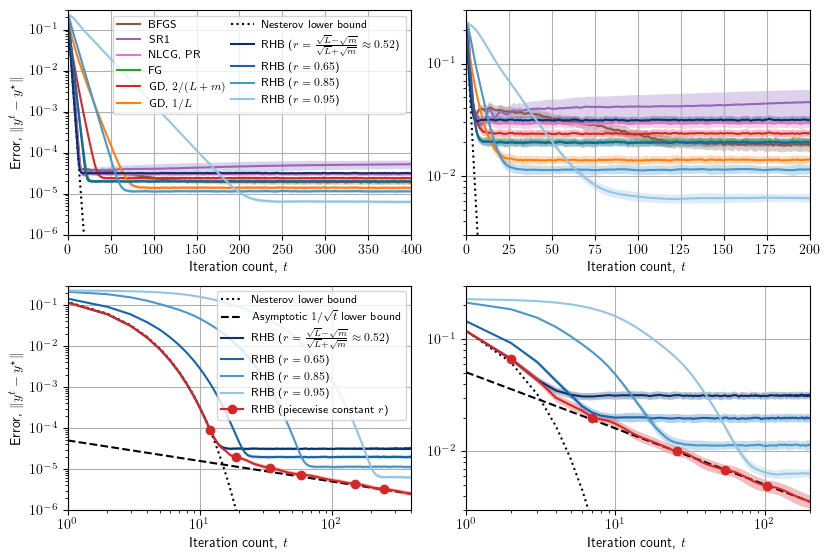

In [449]:
### RUN THIS TWICE TO GET THE COLORS RIGHT

@load DATA * "fig5_simulation_data.jld2" sim iter kvals1 kvals2 L m

using PyCall
cycler = pyimport("cycler")
cm=get_cmap(:tab10)
blues=get_cmap(:Blues)

f, (ax1, ax3, ax2, ax4) = plt.subplots(2, 2, sharey=false, figsize=FIGSIZE .* [1,2])

irange = 0:iter-1
ρnlb = (√L-√m)/(√L+√m) # nesterov lower bound
lbplot = sim[1][1][1][1] * (ρnlb) .^ (0:iter-1)

PyPlot.rc("axes",prop_cycle=cycler.cycler(color=[
            cm(5),
            cm(4),
            cm(6),
            cm(2),
            cm(3),
            cm(1),
            blues(1.0),
            blues(.8),
            blues(.6),
            blues(.4),
            cm(3),
        ]))

########################################################
sca(ax1)
k=0
for (μ,σ,name) in sim[1]
    k += 1
    if k == 7
        plot(irange, lbplot, "k:", label="Nesterov lower bound")
    end
    fill_between(irange, μ-σ, μ+σ, alpha=0.3)
    plot(irange, μ, label=name)
end

yscale("log")
grid("major")

xlabel(L"Iteration count, $t$")
ylabel(L"Error, $\|y^t-y^\star\|$")

xlim(0,400)
ylim(1e-6,3e-1)

legend(loc="upper right",ncol=2, fontsize=8, labelspacing=0.5, columnspacing=0.5)

########################################################
sca(ax2)
plot(irange, lbplot, "k:", label="Nesterov lower bound")

for (μ,σ,name) in sim[2]
    fill_between(irange, μ-σ, μ+σ, alpha=0.3)
    plot(irange, μ, label=name)
end

yscale("log")
grid("major")

xlabel(L"Iteration count, $t$")

xlim(0,200)
ylim(3e-3,3e-1)

########################################################
sca(ax3)
# burn the first 6 colors in the cycle
for _ in 1:6
    plot([0],[0])
    fill_between([0],[0],[0])
end

plot(irange, lbplot, "k:", label="Nesterov lower bound")
plot(irange, sqrt(iter)*sim[3][end][1][end] ./ sqrt.(irange), "k--", label=L"Asymptotic $1/\sqrt{t}$ lower bound")

for (μ,σ,name) in sim[3]
    fill_between(irange, μ-σ, μ+σ, alpha=0.3)
    plot(irange, μ, label=name)
end
plot(kvals1 .- 1, sim[3][end][1][kvals1], "o", color=cm(3))

# just for the label
plot([0],[0], "o-", color=cm(3), label=L"RHB (piecewise constant $\rho$)")

xscale("log")
yscale("log")
grid("major")

xlabel(L"Iteration count, $t$")
ylabel(L"Error, $\|y^t-y^\star\|$")

xlim(1,400)
ylim(1e-6,3e-1)

lll = legend(loc="upper right", fontsize=8, labelspacing=0.5)

lll.get_texts()[7].set_text(L"RHB (piecewise constant $r$)")

########################################################
sca(ax4)

# burn the first 6 colors in the cycle
for _ in 1:6
    plot([0],[0])
    fill_between([0],[0],[0])
end

plot(irange, lbplot, "k:", label="Nesterov lower bound")
plot(irange, sqrt(200)*sim[4][end][1][200] ./ sqrt.(irange), "k--", label=L"Asymptotic $1/\sqrt{t}$ lower bound")

for (μ,σ,name) in sim[4]
    fill_between(irange, μ-σ, μ+σ, alpha=0.3)
    plot(irange, μ, label=name)
end
plot(kvals2 .- 1, sim[4][end][1][kvals2], "o", color=cm(3))

xscale("log")
yscale("log")
grid("major")

xlabel(L"Iteration count, $t$")

xlim(1,200)
ylim(3e-3,3e-1)

tight_layout(pad=0, w_pad=0.5, h_pad=0.8)
if SAVE_FIGS
    savefig(DIR * "fig5_simulation_combo_plot.pdf", pad_inches=0)
end